In [1]:
import glob
import pandas as pd
import numpy as np

import difflib

import plotly.express as px
import plotly.io as pio

# ESL Berlin Group Stage Bias Ratings

In [3]:
resp_data = {}
discord_names = []
team_names = []

for r_file in glob.glob("./data/*"):
    day = r_file[-5]
    # print('day', r_file[-5], 'being parsed', end = '... ')
    tmp = pd.read_csv(r_file)
    
    column_data = {}
    
    for c_n in tmp.columns:
        if ' Vs ' in c_n or ' vs ' in c_n:
            i = ''
            if ' Vs ' in c_n:
                i = c_n.split('Vs')
            elif ' vs ' in c_n:
                i = c_n.split('vs')

            t_1 = i[0].strip()
            t_2 = i[1][:-11].strip()
            column_data[t_1 + ' v ' + t_2] = {'team_1': t_1, 'team_2': t_2}
    
    tmp.rename(columns={tmp.columns.values[1]: 'DISCORD_NAME_ID'}, inplace = True)
    
    tmp['DISCORD_NAME_ID'] = tmp.DISCORD_NAME_ID.fillna('????').astype(str)
    tmp['DISCORD_NAME'] = tmp.DISCORD_NAME_ID.str.strip().apply(lambda x: x[:-5] if '#' in x else x).str.strip()
    tmp['DISCORD_NUM'] = tmp.DISCORD_NAME_ID.str.strip().apply(lambda x: x[-4:] if '#' in x else '????').str.strip()
    
    # name columns and reorder columns
    tmp.columns = np.concatenate((['SUBMIT_TS', 'DISCORD_NAME_ID'], list(column_data.keys()), ['DISCORD_NAME', 'DISCORD_NUM']))
    tmp = tmp[list(np.concatenate((['SUBMIT_TS', 'DISCORD_NAME_ID', 'DISCORD_NAME', 'DISCORD_NUM'], list(column_data.keys()))))]
    
    for col in tmp.columns.drop(['SUBMIT_TS', 'DISCORD_NAME_ID', 'DISCORD_NAME', 'DISCORD_NUM']):
        tmp[col] = tmp[col].str.strip('Victory').str.strip()
    
    # replacing the bad eggs, goddammit
    tmp.replace({'Powdee': 'Powder',
                 'waltz': 'Waltz',
                 'cakes': 'Cakes'}, inplace = True)
    
    # replacing the misspelled teams, goddammit
    tmp.replace({'Tunda Esports': 'Tundra Esports',
                 '9 Panda': '9 Pandas',
                 'Beastcaost': 'Beastcoast',
                 'beastcoast': 'Beastcoast',
                 'Gamin Gladiators': 'Gaimin Gladiators'}, inplace = True)
    
    column_data = pd.DataFrame(column_data).T.replace({'Tunda':' Tundra',
                                                       '9 Panda': '9 Pandas',
                                                       'Beastcaost': 'Beastcoast',
                                                       'beastcoast': 'Beastcoast',
                                                       'Gamin Gladiators': 'Gaimin Gladiators'})
    
    team_names = np.unique(np.append(np.array(team_names), np.unique(column_data.values)))
    
    discord_names = np.unique(np.append(np.array(discord_names), tmp.DISCORD_NAME.unique()))
    
    resp_data[day] = {'dataframe': tmp, 'col_data': column_data}
    
    # print('day', r_file[-5], '-', tmp.shape[0], 'responses parsed!')

In [4]:
for team in team_names:
    if len(difflib.get_close_matches(team, team_names)) > 1:
        print(difflib.get_close_matches(team, team_names))

['Talon Esports', 'Tundra Esports']
['Team Liquid', 'Team Spirit']
['Team SMG', 'Team Spirit']
['Team Spirit', 'Team Liquid', 'Team SMG']
['Tundra Esports', 'Talon Esports']


In [5]:
for name in discord_names:
    if len(difflib.get_close_matches(name, discord_names)) > 1:
        print(difflib.get_close_matches(name, discord_names))

In [6]:
days = np.array(list(resp_data.keys()))
days.sort()

responder_biases = {}

for dn in discord_names:
    responder_biases[dn] = {'DAYS_RESPONDED': 0, 'MATCHES_PREDICTED': 0}
    for team in team_names:
        responder_biases[dn][team] = 0.0

for day in days:
    print('==============\nday', day, 'reponses\n==============')
    day_info = resp_data[day]
    day_frame = day_info['dataframe']
    day_series = day_info['col_data']
    day_frame = day_frame[day_frame.DISCORD_NAME != '????']
    for dn in discord_names:
        dn_data = day_frame[day_frame.DISCORD_NAME == dn]
        
        if dn_data.shape[0]:
            responder_biases[dn]['DAYS_RESPONDED'] += 1
            responder_biases[dn]['MATCHES_PREDICTED'] += day_series.shape[0]
            for series in day_series.index:
                response = day_frame[day_frame.DISCORD_NAME == dn][series].unique()[0]
                
                if response == 'Tie':
                    responder_biases[dn][day_series.loc[series]['team_1']] += 0.5
                    responder_biases[dn][day_series.loc[series]['team_2']] += 0.5
                else:
                    responder_biases[dn][response] += 1
                # print('\t', series, '\t', day_frame[day_frame.DISCORD_NAME == dn][series].unique()[0])
    # print()

day 1 reponses
day 2 reponses
day 3 reponses
day 4 reponses
day 5 reponses


In [7]:
r_bias_df = pd.DataFrame(responder_biases).T.fillna(0.0)

In [8]:
r_bias_df.reset_index(names = 'DISCORD_NAME', inplace = True)

In [9]:
r_bias_df['NA_BIAS'] = (r_bias_df['TSM'] + r_bias_df['Shopify Rebellion']) / r_bias_df['MATCHES_PREDICTED'] * 18 / 2
r_bias_df['SA_BIAS'] = (r_bias_df['Beastcoast'] + r_bias_df['Evil Geniuses']) / r_bias_df['MATCHES_PREDICTED'] * 18 / 2
r_bias_df['WEU_BIAS'] = (r_bias_df['Team Liquid'] + r_bias_df['Tundra Esports'] + r_bias_df['Gaimin Gladiators'] + r_bias_df['OG']) / r_bias_df['MATCHES_PREDICTED'] * 18 / 4
r_bias_df['EEU_BIAS'] = (r_bias_df['9 Pandas'] + r_bias_df['Team Spirit'] + r_bias_df['BetBoom Team']) / r_bias_df['MATCHES_PREDICTED'] * 18 / 3
r_bias_df['SEA_BIAS'] = (r_bias_df['Talon Esports'] + r_bias_df['Execration'] + r_bias_df['Team SMG']) / r_bias_df['MATCHES_PREDICTED'] * 18 / 3
r_bias_df['CN_BIAS'] = (r_bias_df['Xtreme Gaming'] + r_bias_df['PSG.LGD'] + r_bias_df['Invictus Gaming'] + r_bias_df['Team Aster']) / r_bias_df['MATCHES_PREDICTED'] * 18 / 4

In [10]:
r_bias_df.describe()

,DAYS_RESPONDED,MATCHES_PREDICTED,9 Pandas,Beastcoast,BetBoom Team,Evil Geniuses,Execration,Gaimin Gladiators,Invictus Gaming,OG,...,Team SMG,Team Spirit,Tundra Esports,Xtreme Gaming,NA_BIAS,SA_BIAS,WEU_BIAS,EEU_BIAS,SEA_BIAS,CN_BIAS
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,...,40.000000,40.000000,40.00000,40.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,4.050000,59.400000,2.800000,3.312500,3.125000,3.300000,1.012500,5.42500,1.850000,4.087500,...,1.475000,4.212500,4.75000,2.425000,1.143258,1.047991,1.462540,1.015339,0.475694,0.823561
std,1.395046,19.248443,1.399634,1.299346,1.259579,1.362501,0.828092,2.10783,1.038984,1.789884,...,0.823921,1.811245,1.94475,1.525636,0.226736,0.291891,0.176030,0.198710,0.143381,0.156987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.843750,0.500000,1.000000,0.562500,0.160714,0.441964
25%,3.750000,54.000000,1.875000,2.500000,2.000000,2.500000,0.500000,4.50000,1.000000,3.000000,...,0.875000,3.000000,3.75000,1.500000,0.992188,0.879464,1.351562,0.838542,0.375000,0.777344
50%,5.000000,72.000000,3.000000,3.000000,3.000000,3.500000,0.750000,6.00000,1.750000,4.500000,...,1.500000,4.500000,5.00000,2.500000,1.125000,1.000000,1.446429,1.041667,0.468750,0.843750
75%,5.000000,72.000000,4.000000,4.000000,4.000000,4.500000,1.500000,7.00000,2.500000,5.125000,...,2.000000,5.500000,6.50000,3.000000,1.200335,1.218750,1.600446,1.145833,0.583333,0.925781
max,5.000000,72.000000,5.500000,6.500000,6.000000,5.500000,3.500000,8.00000,4.000000,7.500000,...,3.000000,6.500000,7.50000,6.000000,1.687500,1.968750,1.757812,1.375000,0.791667,1.218750


In [16]:
r_bias_df.to_parquet('./results/esl_berlin_group_biases.gzip', compression = 'gzip')
r_bias_df.to_csv('./results/esl_berlin_group_biases.csv')

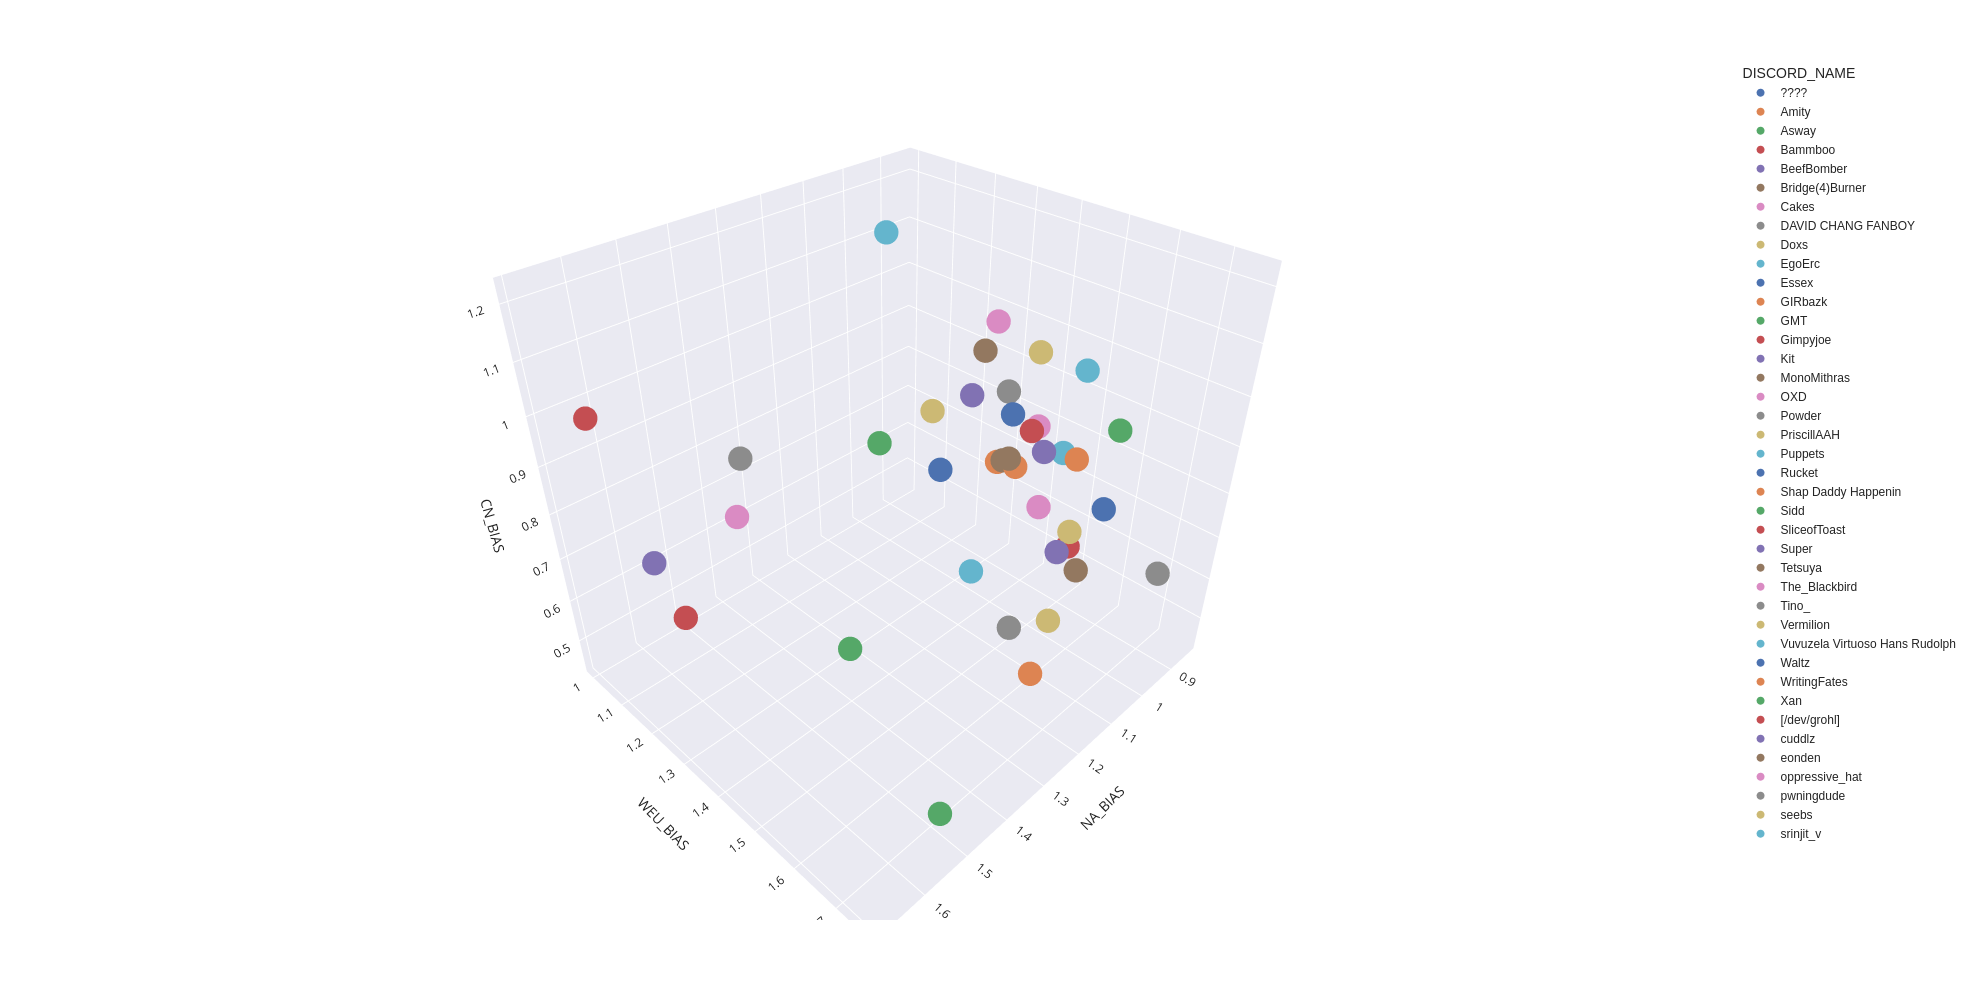

In [15]:
fig = px.scatter_3d(r_bias_df, x='NA_BIAS', y='WEU_BIAS', z='CN_BIAS', color='DISCORD_NAME', template = 'seaborn', height=1000)
fig.show()

fig.write_html("./results/esl_berlin_group_stage_bias.html")